In [1]:
import os
import sys
sys.path.append("..")
import canon

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm
from mpl_toolkits.axes_grid1 import Grid
from PIL import Image
%matplotlib inline

import tensorflow as tf
import keras, keras.layers as L, keras.backend as K

from canon.autoencode.feeder import ImageDataFeeder

# IMAGE_DIR = os.path.join("img", "processed_981")
# TEST_DIR = os.path.join("img", "test_981")
IMAGE_DIR = os.path.join("img", "training_20190517")
TEST_DIR = os.path.join("img", "validation_20190517")
filenames = [filename for filename in os.listdir(IMAGE_DIR)]
IMAGE_SHAPE = (128, 128)
feeder = ImageDataFeeder(IMAGE_SHAPE, batch_size=30, training_dir=IMAGE_DIR, test_dir=TEST_DIR)
X_test = feeder.get_test_set()

Using TensorFlow backend.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  1

In [2]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f_beta(y_true, y_pred, beta=1):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return (1 + beta**2)*((p*r)/((beta**2)*p+r+K.epsilon()))

In [30]:
import canon.autoencode
from canon.autoencode import reset_tf_session
from canon.autoencode.models import load_encoder, load_decoder

s = reset_tf_session()
model_name = "ae_conv_4_256"
encoder = load_encoder(model_name)
decoder = load_decoder(model_name)
encoder.summary()
decoder.summary()

inp = L.Input(IMAGE_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)
autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adam", loss='binary_crossentropy', metrics=['mse', f_beta])
reconstruction_mse = autoencoder.evaluate(X_test, X_test, verbose=1)
print("Convolutional Autoencoder Binary CrossEntropy:", reconstruction_mse)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 16)      160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxP

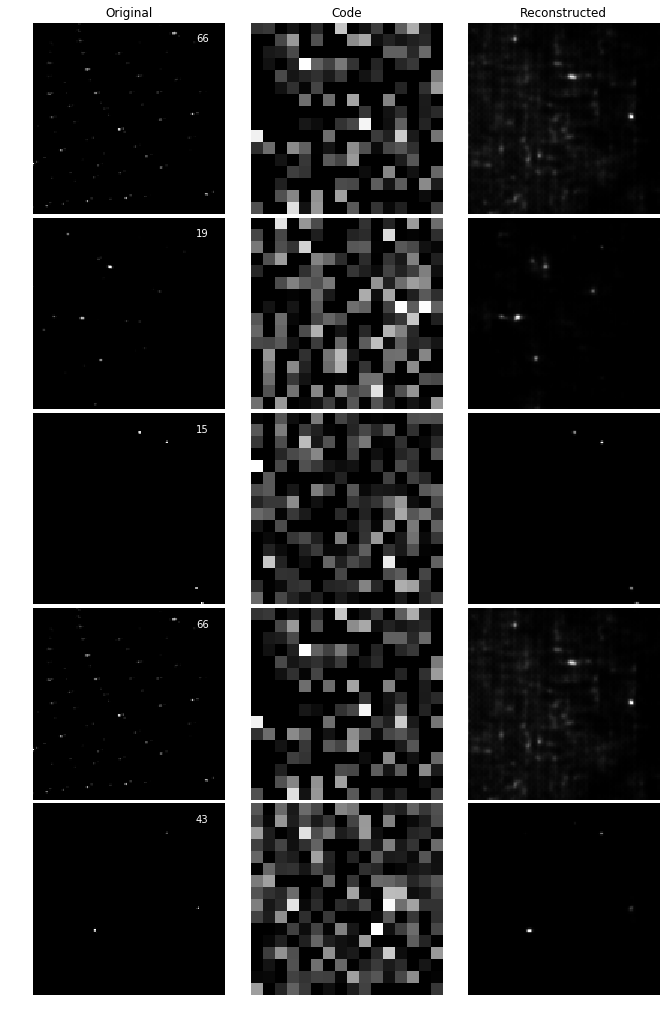

In [35]:
fig, ax = plt.subplots(5, 3, figsize=(10, 15))
for i, idx in enumerate(np.random.choice(len(X_test), 5)):
    img = X_test[idx]
    code = encoder.predict(img[None])[0]  # img[None] is the same as img[np.newaxis, :]
    reco = decoder.predict(code[None])[0]

    ax0 = ax[i, 0]
    ax0.imshow(img, cmap='gray')
    ax0.axis('off')

    ax1 = ax[i, 1] 
    if np.prod(code.shape) == 32:
        code_shape = (8, 4)
    elif np.prod(code.shape) == 128:
        code_shape = (16, 8)
    elif np.prod(code.shape) == 512:
        code_shape = (32, 16)
    else:
        code_shape = [int(np.ceil(np.sqrt(code.shape[-1]))),-1]
    ax1.imshow(code.reshape(code_shape), cmap='gray')
    ax1.axis('off')

    ax2 = ax[i, 2] 
    # plt.title("Reconstructed")
    ax2.imshow(reco, cmap='gray')
    ax2.axis('off')
    
    ax0.text(0.85, 0.9, "%d" % idx, color='w', fontsize=10, transform=ax0.transAxes)
    if i == 0:
        ax0.set_title(r'Original', fontsize=12)
        ax1.set_title(r'Code', fontsize=12)
        ax2.set_title(r'Reconstructed', fontsize=12)

fig.subplots_adjust(bottom=0, top=0.9, left=0, right=0.9, wspace=0.02, hspace=0.02)

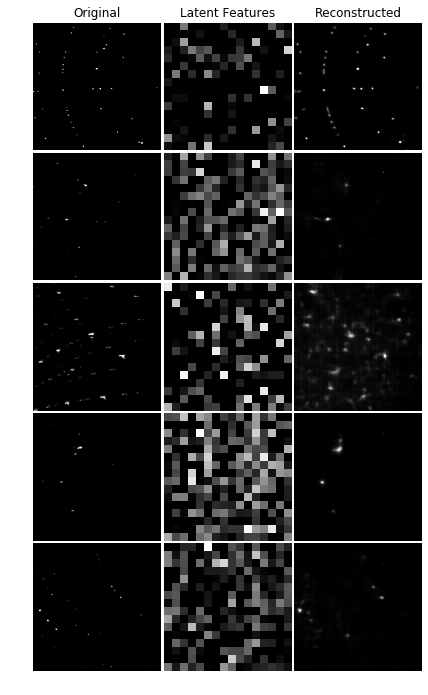

In [55]:
# image 96, 25, 99, 49, 64, 2
# image 35, 27, 17, 36, 79

fig, ax = plt.subplots(5, 3, figsize=(6, 10))
for i, idx in enumerate([35, 27, 17, 36, 79][:5]):
    img = X_test[idx]
    code = encoder.predict(img[None])[0]  # img[None] is the same as img[np.newaxis, :]
    reco = decoder.predict(code[None])[0]

    ax0 = ax[i, 0]
    ax0.imshow(img, cmap='gray')
    ax0.axis('off')

    ax1 = ax[i, 1] 
    if np.prod(code.shape) == 32:
        code_shape = (8, 4)
    elif np.prod(code.shape) == 128:
        code_shape = (16, 8)
    else:
        code_shape = [int(np.ceil(np.sqrt(code.shape[-1]))),-1]
    ax1.imshow(code.reshape(code_shape), cmap='gray')
    ax1.axis('off')

    ax2 = ax[i, 2] 
    ax2.imshow(reco, cmap='gray')
    ax2.axis('off')
    
    if i == 0:
        ax0.set_title(r'Original', fontsize=12)
        ax1.set_title(r'Latent Features', fontsize=12)
        ax2.set_title(r'Reconstructed', fontsize=12)

fig.subplots_adjust(bottom=0, top=0.9, left=0, right=0.9, wspace=0.02, hspace=0.02)
fig.savefig("img/review_model.pdf", bbox_inches='tight', dpi=300)

['epoch', 'loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error']


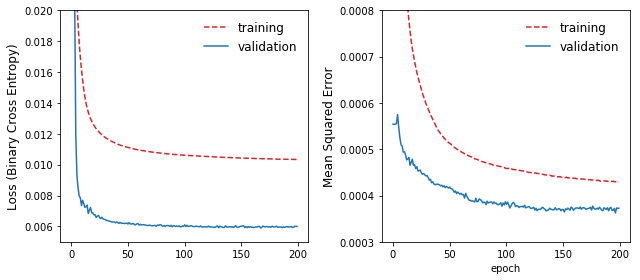

In [36]:
import csv

hist_csv = os.path.join("checkpoints", "conv_4", "256", "history.csv")
with open(hist_csv, 'r') as f_csv:
    reader = csv.reader(f_csv)
    headers = None
    X_data = []
    Y_data = []
    for row in reader:
        if headers is None:
            headers = row
            print(headers)
        else:
            X_data += [int(row[0])]
            Y_data += [[float(row[1]), float(row[2]), float(row[3]), float(row[4])]]

Y_data = np.array(Y_data)[15 : 15 + 200]
X_data = np.arange(Y_data.shape[0])
            
fig, ax = plt.subplots(1, 2, figsize=(9, 4))
ax[0].plot(X_data, Y_data[:, 0], label='training', color='tab:red', ls='--')
ax[0].plot(X_data, Y_data[:, 2], label='validation', color='tab:blue')
ax[0].set_ylim(0.005, 0.02)
ax[0].set_ylabel('Loss (Binary Cross Entropy)', fontsize=12)
ax[0].legend(frameon=False, fontsize=12)
ax[1].plot(X_data, Y_data[:, 1], label='training', color='tab:red', ls='--')
ax[1].plot(X_data, Y_data[:, 3], label='validation', color='tab:blue')
ax[1].set_ylim(3E-4, 8E-4)
ax[1].legend(frameon=False, fontsize=12)
ax[1].set_ylabel('Mean Squared Error', fontsize=12)
ax[1].set_xlabel('epoch')
plt.tight_layout()
fig.savefig("img/training_history.pdf", dpi=300)